# Benchmarking Feature Extractors and Matchers

This notebook evaluates the performance of different local feature extractors (SuperPoint, DISK, and SIFT) and the LightGlue matcher on a pair of original images.  

Additionally, we test the robustness of the SuperPoint + LightGlue pipeline under various image transformations, including rotation, brightness changes, and blur.  

Metrics measured include:  
- Number of keypoints detected  
- Number of matches  
- Execution time  
- Matching robustness under variations  

**Work done by:** Zakaria Zaouak, Salma Azzimani, Lina Toumi



# Setup & Imports




In [2]:
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

/content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lightglue (pyproject.toml) ... done


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
def create_matcher(depth=4, prune=0.5,n_layers=None):
    return LightGlue(features="superpoint", depth=depth, prune=prune, n_layers=n_layers).eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth


100%|██████████| 4.96M/4.96M [00:00<00:00, 215MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os
os.chdir("/content/drive/MyDrive/projet_vision")


Matchers Configuration


In [6]:
matcher1 = create_matcher(n_layers=2)
matcher2 = create_matcher(n_layers=4)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth


100%|██████████| 45.3M/45.3M [00:00<00:00, 272MB/s]


In [7]:
import time

Feature Extraction & Matching Visualization


In [8]:
# First run with matcher1
# image0 = load_image("DSC_0411.JPG")
# image1 = load_image("DSC_0410.JPG")

# feats0 = extractor.extract(image0.to(device))
# feats1 = extractor.extract(image1.to(device))
# matches01 = matcher1({"image0": feats0, "image1": feats1})
# feats0, feats1, matches01 = [
#     rbd(x) for x in [feats0, feats1, matches01]
# ]  # remove batch dimension

# kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
# m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

# axes = viz2d.plot_images([image0, image1])
# viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
# viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

# kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

# Second run with matcher2
image0 = load_image("DSC_0411.JPG")
image1 = load_image("DSC_0410.JPG")

start_time = time.time()
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher2({"image0": feats0, "image1": feats1})
end_time = time.time()
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)


Output hidden; open in https://colab.research.google.com to view.

In [9]:
print(f"Extraction + matching time: {end_time - start_time:.3f}s")

Extraction + matching time: 3.643s


In [10]:
num_kpts0 = kpts0.shape[0]
num_kpts1 = kpts1.shape[0]
print("Original keypoints: image0:", num_kpts0, "image1:", num_kpts1)


Original keypoints: image0: 2048 image1: 2048


In [11]:
num_matches = matches.shape[0]
print("Number of matched keypoints:", num_matches)


Number of matched keypoints: 1062


In [12]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import pandas as pd
from pathlib import Path

Generate Image Variations


In [13]:
def create_variations(image_path):
    img = Image.open(image_path)
    Path("variations").mkdir(exist_ok=True)
    base = Path(image_path).stem

    # Rotation
    for angle in [15, 30, 45]:
        img.rotate(angle, expand=True).save(f"variations/{base}_rot{angle}.jpg")

    # Brightness
    for factor in [0.6, 1.4]:
        ImageEnhance.Brightness(img).enhance(factor).save(f"variations/{base}_bright{factor}.jpg")

    # Blur
    for radius in [2, 4]:
        img.filter(ImageFilter.GaussianBlur(radius)).save(f"variations/{base}_blur{radius}.jpg")

create_variations("DSC_0411.JPG")
create_variations("DSC_0410.JPG")
print("Variations created!")

Variations created!


# Benchmark SuperPoint vs DISK vs SIFT

In [20]:
disk_extractor = DISK(max_num_keypoints=2048).eval().to(device)
matcher = LightGlue(features="superpoint", depth=9, prune=0.5).eval().to(device)
matcher_disk = LightGlue(features="disk", depth=9, prune=0.5).eval().to(device)

results = []

# Test SuperPoint
img0 = load_image("DSC_0411.JPG")
img1 = load_image("DSC_0410.JPG")

start = time.time()
feats0 = extractor.extract(img0.to(device))
feats1 = extractor.extract(img1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
elapsed = time.time() - start
num_matches = rbd(matches01)["matches"].shape[0]
results.append({'extractor': 'SuperPoint', 'matches': num_matches, 'time': elapsed})
print(f"SuperPoint: {num_matches} matches in {elapsed:.3f}s")

# Test DISK
start = time.time()
feats0 = disk_extractor.extract(img0.to(device))
feats1 = disk_extractor.extract(img1.to(device))
matches01 = matcher_disk({"image0": feats0, "image1": feats1})
elapsed = time.time() - start
num_matches = rbd(matches01)["matches"].shape[0]
results.append({'extractor': 'DISK', 'matches': num_matches, 'time': elapsed})
print(f"DISK: {num_matches} matches in {elapsed:.3f}s")

SuperPoint: 1062 matches in 0.160s
DISK: 1045 matches in 0.411s


In [21]:
# Convert torch image to numpy grayscale
def torch_to_gray(img):
    img = img.cpu().numpy()
    img = (img * 255).astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))  # C,H,W → H,W,C
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

# SIFT setup
sift = cv2.SIFT_create()
MAX_KPTS = 2048

# Prepare images
img0_gray = torch_to_gray(image0)
img1_gray = torch_to_gray(image1)

# Timing start
start_time = time.time()

# Detect all keypoints (NO unpacking)
kp0 = sift.detect(img0_gray, None)
kp1 = sift.detect(img1_gray, None)

# Keep strongest keypoints only
kp0 = sorted(kp0, key=lambda x: x.response, reverse=True)[:MAX_KPTS]
kp1 = sorted(kp1, key=lambda x: x.response, reverse=True)[:MAX_KPTS]

# Compute descriptors for selected keypoints
kp0, desc0 = sift.compute(img0_gray, kp0)
kp1, desc1 = sift.compute(img1_gray, kp1)

# Match descriptors
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(desc0, desc1, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Timing end
end_time = time.time()

In [22]:
print("----- SIFT Metrics -----")
print("Execution time (s):", end_time - start_time)
print("Keypoints image 0:", len(kp0))
print("Keypoints image 1:", len(kp1))
print("Number of matches:", len(good_matches))

----- SIFT Metrics -----
Execution time (s): 0.9053874015808105
Keypoints image 0: 2048
Keypoints image 1: 2048
Number of matches: 342


# Test Robustness on Image Variations


=== TESTING MATCHER ON IMAGE VARIATIONS ===
Extractor: SuperPoint (max_keypoints=2048)
Matcher: LightGlue (n_layers=4, prune=default)

BASELINE (original pair): 1062 matches
--------------------------------------------------
BLUR         | blur2      |  813 matches ( 76.6% of baseline)
BLUR         | blur4      |  512 matches ( 48.2% of baseline)
BRIGHTNESS   | bright0.6  | 1030 matches ( 97.0% of baseline)
BRIGHTNESS   | bright1.4  | 1042 matches ( 98.1% of baseline)
ROTATION     | rot15      |  999 matches ( 94.1% of baseline)
ROTATION     | rot30      |  974 matches ( 91.7% of baseline)
ROTATION     | rot45      |  875 matches ( 82.4% of baseline)


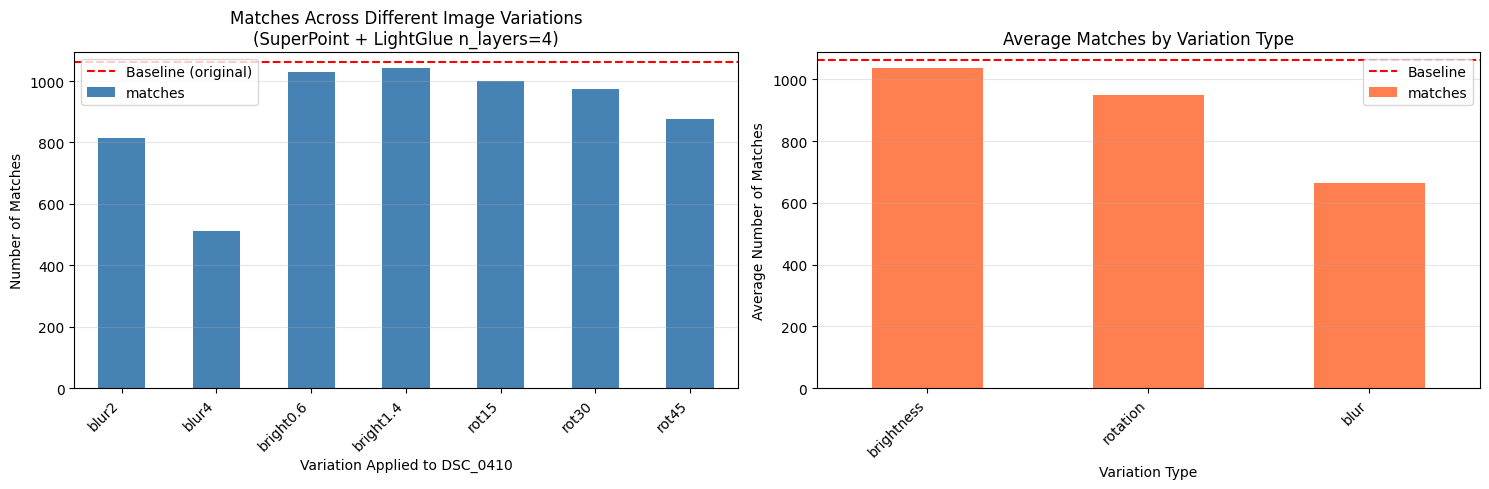


=== SUMMARY ===
Most robust to: bright1.4 (1042 matches)
Least robust to: blur4 (512 matches)
Average degradation: 16.0%


In [18]:
variations = list(Path("variations").glob("DSC_0410_*.jpg"))
results = []

print("=== TESTING MATCHER ON IMAGE VARIATIONS ===")
print(f"Extractor: SuperPoint (max_keypoints=2048)")
print(f"Matcher: LightGlue (n_layers=4, prune=default)\n")

# Test original first
img0 = load_image("DSC_0411.JPG")
img1 = load_image("DSC_0410.JPG")

feats0 = extractor.extract(img0.to(device))
feats1 = extractor.extract(img1.to(device))
matches01 = matcher2({"image0": feats0, "image1": feats1})
num_matches = rbd(matches01)["matches"].shape[0]
results.append({'variation_type': 'original', 'variation': 'none', 'matches': num_matches})
print(f"BASELINE (original pair): {num_matches} matches")
print("-" * 50)

# Test variations
for var_path in sorted(variations):
    img0 = load_image("DSC_0411.JPG")
    img1 = load_image(str(var_path))

    # Determine variation type
    stem = var_path.stem
    if 'rot' in stem:
        var_type = 'rotation'
        var_detail = stem.split('_')[-1]  # e.g., "rot15"
    elif 'bright' in stem:
        var_type = 'brightness'
        var_detail = stem.split('_')[-1]
    elif 'blur' in stem:
        var_type = 'blur'
        var_detail = stem.split('_')[-1]
    else:
        var_type = 'other'
        var_detail = stem

    feats0 = extractor.extract(img0.to(device))
    feats1 = extractor.extract(img1.to(device))
    matches01 = matcher2({"image0": feats0, "image1": feats1})

    num_matches = rbd(matches01)["matches"].shape[0]
    match_ratio = (num_matches / results[0]['matches']) * 100  # % of baseline

    results.append({
        'variation_type': var_type,
        'variation': var_detail,
        'matches': num_matches,
        'match_ratio': match_ratio
    })

    print(f"{var_type.upper():12} | {var_detail:10} | {num_matches:4} matches ({match_ratio:5.1f}% of baseline)")

df_var = pd.DataFrame(results)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Bar chart by variation
df_var[1:].plot(x='variation', y='matches', kind='bar', ax=ax1, legend=False, color='steelblue')
ax1.axhline(y=results[0]['matches'], color='red', linestyle='--', label='Baseline (original)')
ax1.set_title("Matches Across Different Image Variations\n(SuperPoint + LightGlue n_layers=4)")
ax1.set_ylabel("Number of Matches")
ax1.set_xlabel("Variation Applied to DSC_0410")
ax1.legend()
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Grouped by type
grouped = df_var[1:].groupby('variation_type')['matches'].mean().sort_values(ascending=False)
grouped.plot(kind='bar', ax=ax2, color='coral')
ax2.axhline(y=results[0]['matches'], color='red', linestyle='--', label='Baseline')
ax2.set_title("Average Matches by Variation Type")
ax2.set_ylabel("Average Number of Matches")
ax2.set_xlabel("Variation Type")
ax2.legend()
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== SUMMARY ===")
print(f"Most robust to: {df_var[1:].loc[df_var[1:]['matches'].idxmax(), 'variation']} ({df_var[1:]['matches'].max()} matches)")
print(f"Least robust to: {df_var[1:].loc[df_var[1:]['matches'].idxmin(), 'variation']} ({df_var[1:]['matches'].min()} matches)")
print(f"Average degradation: {100 - df_var[1:]['match_ratio'].mean():.1f}%")